# Variational Autoencoder

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/05_03_Autoencoder_Alt.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/05_03_Autoencoder_Alt.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Introduction

This notebook was used to play around with some different ways of doing autoencoders in tensorflow, in particular with some sequence data, in anticipation of the notebook 06_03_DisentangledSequentialAE.

## Prepare Notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import sys


try:
    # See if we are running on google.colab
    from google.colab import files
    %tensorflow_version 2.x
    os.chdir('..')
    
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json

    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
        
    !pip install git+https://github.com/SachsLab/indl.git
    !pip install -q kaggle
    !pip install --upgrade tensorflow-probability
    IN_COLAB = True

except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfkl
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [4]:
if True:
    plt.style.use('dark_background')
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.figsize': (6.4, 6.4)
})

## Prepare Data

While I'm figuring this out, I'll use a contrived dataset. Let's assume that we have N_LATENT different latent variables. Each latent variable evolves over time. The evolution of each latent (i.e., its dynamics) over time is described by a sinusoid. The sinusoid is modulated by a sigmoid function with amplitude conditioned on the trial label, of which there are N_CLASSES distinct classes. The evolved conditionally-dependent latent variables are then mixed to yield N_SENSORS sensor-space signals, using a static mixing matrix.

In [5]:
from indl.misc.sigfuncs import sigmoid
from functools import partial


N_LATENTS = 4
N_SENSORS = 32
N_CLASSES = 5
FS = 64
DURATION = 2  # seconds
n_timesteps = int(DURATION * FS)

np.random.seed(66)
x = np.arange(n_timesteps) / FS
lat_freqs = np.random.uniform(low=0.5, high=2.5, size=(N_LATENTS,))
class_amps = np.random.uniform(low=-1.0, high=1.0, size=(N_CLASSES,))
mix_mat = np.random.randn(N_SENSORS, N_LATENTS)
mix_mat /= np.max(np.abs(mix_mat))

latent_protos = np.sin(lat_freqs[:, None]*2*np.pi*x[None, :])
f_sig = partial(sigmoid, B=5, x_offset=1.0)
latent_mods = class_amps[:, None] * f_sig(x)[None, :]
latent_class_dat = latent_mods[None, :, :] * latent_protos[:, None, :]
sensor_class_dat = mix_mat @ latent_class_dat.reshape(N_LATENTS, N_CLASSES * n_timesteps)
sensor_class_dat = sensor_class_dat.reshape(N_SENSORS, N_CLASSES, n_timesteps)
sensor_class_dat = np.transpose(sensor_class_dat, [1, 2, 0])
print(sensor_class_dat.shape)

(5, 128, 32)


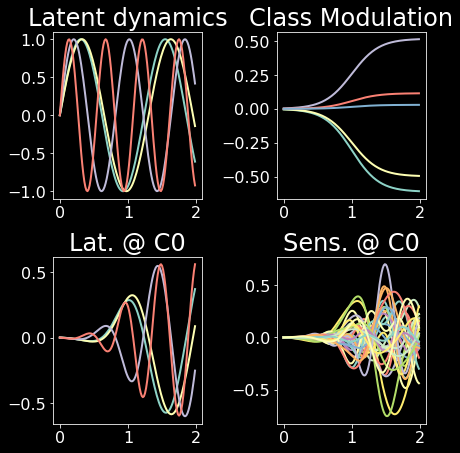

In [6]:
plt.subplot(2, 2, 1)
plt.plot(x, latent_protos.T)
plt.title("Latent dynamics")

plt.subplot(2, 2, 2)
plt.plot(x, latent_mods.T)
plt.title("Class Modulation")

plot_class_ix = 0
plt.subplot(2, 2, 3)
plt.plot(x, latent_class_dat[:, plot_class_ix, :].T)
plt.title(f"Lat. @ C{plot_class_ix}")

plt.subplot(2, 2, 4)
plt.plot(x, sensor_class_dat[plot_class_ix])
plt.title(f"Sens. @ C{plot_class_ix}")

plt.tight_layout()
plt.show()

We will draw samples from `sensor_class_dat` with added noise.
Compare the plotted example below to the plot from the lower-right pane above.

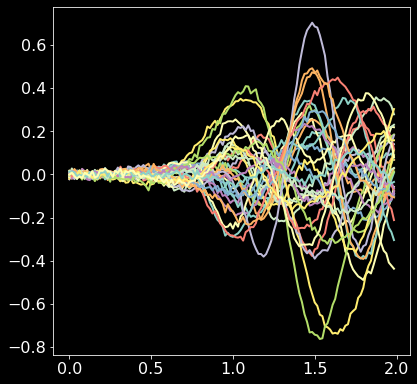

In [7]:
def draw_samples(class_idx, noise_std=0.01):
    dat = np.copy(sensor_class_dat[class_idx]).astype(np.float32)
    dat += np.random.normal(loc=0, scale=noise_std, size=dat.shape)
    return dat
    
plt.plot(x, draw_samples([plot_class_ix])[0])
plt.show()

In [8]:
N_TRIALS = 10000
BATCH_SIZE = 64

Y = np.random.randint(0, high=N_CLASSES, size=N_TRIALS)
X = draw_samples(Y)
dataset = tf.data.Dataset.from_tensor_slices((X, Y)).batch(BATCH_SIZE, drop_remainder=True)
dataset.element_spec

(TensorSpec(shape=(64, 128, 32), dtype=tf.float32, name=None),
 TensorSpec(shape=(64,), dtype=tf.int32, name=None))

## Sanity Check - GRU Classifier

We want to make sure that we can train a recurrent model to classify the data. As one of the main use-cases for us for an AE is for model pretraining and transfer to the classifier task, we would not usually *start* with classification. Here we are running a classifier first just to make sure our data may be classified using a RNN.

In [9]:
N_GRU = 50
N_EPOCHS = 2

K.clear_session()
model = tf.keras.Sequential(
    [tfkl.Input(shape=(n_timesteps, N_SENSORS)),
     tfkl.GRU(N_GRU, return_sequences=False),
     tfkl.Dense(N_CLASSES, activation='softmax')]
)
model.summary()
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(dataset, epochs=N_EPOCHS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                12600     
_________________________________________________________________
dense (Dense)                (None, 5)                 255       
Total params: 12,855
Trainable params: 12,855
Non-trainable params: 0
_________________________________________________________________
Train for 156 steps
Epoch 1/2
156/156 [==============================] - 5s 34ms/step - loss: 0.6015 - accuracy: 0.7729
Epoch 2/2
156/156 [==============================] - 2s 10ms/step - loss: 0.0190 - accuracy: 1.0000


In [10]:
pred_y = []
true_y = []
for batch_ix in range(X.shape[0] // BATCH_SIZE):
    _sl = np.s_[batch_ix * BATCH_SIZE : (batch_ix + 1) * BATCH_SIZE]
    pred_y.append(np.argmax(model.predict(X[_sl]), axis=1))
    true_y.append(Y[_sl])

tf.Tensor(
[[1952    0    0    0    0]
 [   0 2016    0    0    0]
 [   0    0 2000    0    0]
 [   0    0    0 2014    0]
 [   0    0    0    0 2002]], shape=(5, 5), dtype=int32)


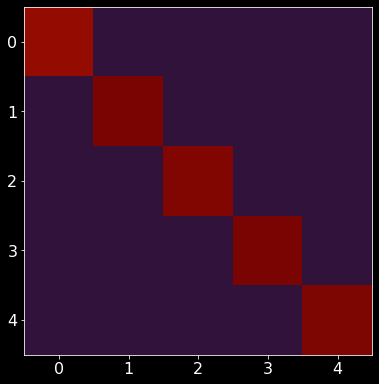

In [11]:
import indl.display  # To register 'turbo'


conf_mat = tf.math.confusion_matrix(np.array(true_y).flatten(), np.array(pred_y).flatten(), num_classes=N_CLASSES)
plt.imshow(conf_mat, cmap='turbo')
print(conf_mat)

## Basic Sequential Autoencoder

Before we get into the fancy **disentangled & variational** autoencoder, let's start with a simple one.

### Modify dataset

The autoencoder tries to reconstruct the input, so we need the 'labels' in the dataset to be a copy of the input. We do this by mapping a function to the dataset, where the function is a simple lambda that takes in x,y and returns x,x.

In [13]:
ae_dataset = dataset.map(lambda x, y: (x, x))
print(ae_dataset.element_spec)

(TensorSpec(shape=(64, 128, 32), dtype=tf.float32, name=None), TensorSpec(shape=(64, 128, 32), dtype=tf.float32, name=None))


Below we take the single timestep output of the encoder GRU and repeat it to be as long as the timesteps on the input. This is not the only way. TODO: Try other ways.

* Set decoder hidden state using encoder output, then feedback output of decoder into itself
* Set hidden state and/or first input, then the rest of the inputs are zeros.

[See here](https://stackoverflow.com/a/55000744/1256069)

In [14]:
N_EPOCHS = 30
LATENT_DIM = 64


K.clear_session()
model = tf.keras.Sequential([
    tfkl.Input(shape=(n_timesteps, N_SENSORS)),
    tfkl.GRU(LATENT_DIM, return_sequences=False),  # encoder: to latent
    tfkl.RepeatVector(n_timesteps),                # decoder a: upsample latent
    tfkl.GRU(N_SENSORS, return_sequences=True)     # decoder b: generate sequence
])
model.summary()
model.compile(loss='mse', 
              optimizer='nadam')
history = model.fit(ae_dataset, epochs=N_EPOCHS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                18816     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 128, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128, 32)           9408      
Total params: 28,224
Trainable params: 28,224
Non-trainable params: 0
_________________________________________________________________
Train for 156 steps
Epoch 1/30
156/156 [==============================] - 4s 25ms/step - loss: 0.0106
Epoch 2/30
156/156 [==============================] - 2s 11ms/step - loss: 0.0105
Epoch 3/30
156/156 [==============================] - 2s 11ms/step - loss: 0.0105
Epoch 4/30
156/156 [==============================] - 2s 11ms/step - loss: 0.0102
Epoch 5/30
156/156 [==============

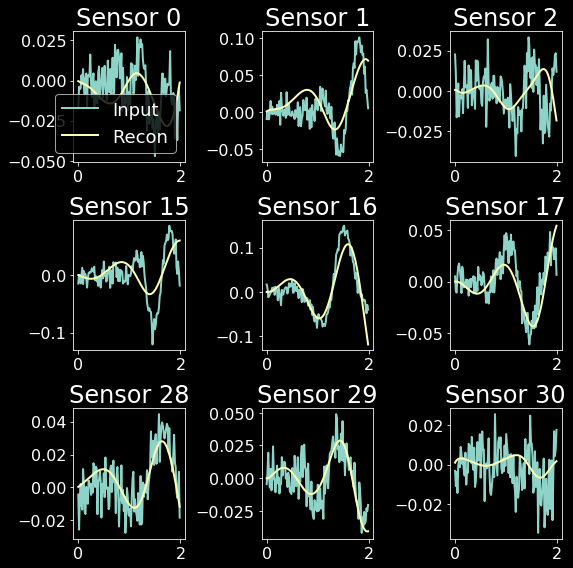

In [15]:
plt.figure(figsize=(8, 8))

trial_ix = 10
test_X = X[trial_ix, :, :][None, ...]
recon_X = model(test_X).numpy()
for chan_ix, chan_idx in enumerate([0, 1, 2, 15, 16, 17, 28, 29, 30]):
    plt.subplot(3, 3, chan_ix + 1)
    plt.plot(x, test_X[0, :, chan_idx], label="Input")
    plt.plot(x, recon_X[0, :, chan_idx], label="Recon")
    plt.title(f"Sensor {chan_idx}")
    if chan_ix == 0:
        plt.legend()

plt.tight_layout()
plt.show()

## Variational Autoencoder with vanilla TF and Keras

Next, we take the relatively large step of making the variational autoencoder using vanilla TF. To do it correctly is quite a bit more involved than making it with tensorflow-probability, which we will see later.

The first major difference between a regulary AE and a VAE is how the latent variables are used as input to the decoder. In the regular AE, latent variables are unchanged inputs to the decoder. In a VAE, latent variables parameterize a sampling from a normal distribution. In vanilla TF, the distribution itself cannot be back-propagated over so it uses a trick to learn a twice-as-big latent vector, where the first half is assumed to be the mean and the second half is the variance (actually log variance), and the input to the decoder is sampled as `mean + e^log_sigma * sample_from_mean0_std1`.

Much of the below code was cobbled together from online examples.

* [Official TF guide to convolutional VAE](https://www.tensorflow.org/tutorials/generative/cvae)
* [The Keras blog post on autoencoders](https://blog.keras.io/building-autoencoders-in-keras.html) (ctrl+F Variational autoencoder)
* [LSTM version of above](https://github.com/twairball/keras_lstm_vae/blob/master/lstm_vae/vae.py).

In [16]:
N_EPOCHS = 30
N_GRU = 100
LATENT_DIM = 50

K.clear_session()

# Encoder
_input = tfkl.Input(shape=(n_timesteps, N_SENSORS))
if True:
    _x = tfkl.GRU(LATENT_DIM * 2)(_input)
    _mean, _log_sigma = tf.split(_x, num_or_size_splits=2, axis=1)
else:
    _x = tfkl.GRU(N_GRU)(_input)
    _mean, _log_sigma = tfkl.Dense(LATENT_DIM)(_x), tfkl.Dense(LATENT_DIM)(_x)

# Decoder
# Draw a random vector from a normal distribution.
# - Unfortunately this requires specifying the batch size so the right number of samples are drawn.
#   (None, LATENT_DIM) doesn't work.
if True:
    _z = _mean + tf.random.normal(shape=(BATCH_SIZE, LATENT_DIM)) * tf.exp(_log_sigma * .5)
else:
    # Use a func wrapped in a layers.Lambda to make the model summary a little cleaner.
    # However, this provides objectively worse reconstruction. Why?
    def sampling(args):
        z_mean, z_log_sigma = args
        eps = K.random_normal(shape=(BATCH_SIZE, LATENT_DIM))
        # Note: *.5 in TF guide but not Keras blog.
        return z_mean + K.exp(z_log_sigma * .5) * eps
    _z = tfkl.Lambda(sampling)([_mean, _log_sigma])

_y0 = tfkl.RepeatVector(n_timesteps)(_z)
_y1 = tfkl.GRU(N_GRU, return_sequences=True)(_y0)  # Model capacity seems inadequate without this.
_y = tfkl.GRU(N_SENSORS, return_sequences=True)(_y1)

# end-to-end model
vae_model = tf.keras.Model(_input, _y)
vae_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 32)]    0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 100)          40200       input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_split (TensorFlowOp [(None, 50), (None,  0           gru[0][0]                        
__________________________________________________________________________________________________
tf_op_layer_mul (TensorFlowOpLa [(None, 50)]         0           tf_op_layer_split[0][1]          
______________________________________________________________________________________________

### Custom Loss

The second major difference between a regular AE and VAE is a new loss in addition to the reconstruction loss. The new loss is intended to penalize a divergence of the latent variable distribution from the target distribution. (TODO: What is the target distribution? Normal?) The *Kullback-Leibler (KL) divergence* metric measures differences in information contained within two distributions. This difference is minimized by maximizing the "variational lower bound" (a.k.a. evidence of lower bound, or ELBO). Thus, we add to our model a loss that represents the negative of the ELBO.

Note that if we include this loss at its full value from the very beginning, the loss landscape might lead us to a minimum that keeps these distributions similar but does poorly at reconstructing our input. It's fairly typical to ramp up the contribution of the KL loss as training progresses. However, that requires a custom training loop and the ultimate goal of this notebook is not this model but another one, so let's not bother doing the custom training loop here. Instead we'll decrease the contribution of the KL loss somewhat and leave it constant.

In [17]:
# We would need a custom training loop to properly ramp beta up to 1.0 over epochs.
# For now we just set it to a low enough constant that we can still get some
# reconstruction.
BETA = 0.2
kl_loss = -0.5 * K.mean(1 + _log_sigma - K.square(_mean) - K.exp(_log_sigma), axis=-1)
kl_loss = BETA * kl_loss
# Note, in Guillaume's formulation, the loss is first summed then mean (over what dim?)
    
vae_model.add_loss(kl_loss)
vae_model.compile(loss='mse', 
                  optimizer='nadam')

In [18]:
history = vae_model.fit(ae_dataset, epochs=N_EPOCHS)  # Target loss around 0.001

Train for 156 steps
Epoch 1/30
156/156 [==============================] - 6s 40ms/step - loss: 0.0219
Epoch 2/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0108
Epoch 3/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0106
Epoch 4/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0106
Epoch 5/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0105
Epoch 6/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0105
Epoch 7/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0104
Epoch 8/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0103
Epoch 9/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0101
Epoch 10/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0100
Epoch 11/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0098
Epoch 12/30
156/156 [==============================] - 3s 18ms/step - loss: 

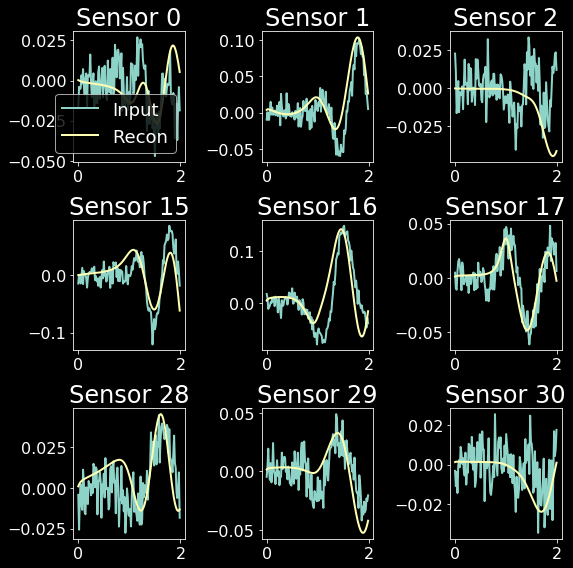

In [19]:
plt.figure(figsize=(8, 8))

trial_ix = 10
test_X = X[trial_ix, :, :][None, ...]
recon_X = vae_model(test_X).numpy()
for chan_ix, chan_idx in enumerate([0, 1, 2, 15, 16, 17, 28, 29, 30]):
    plt.subplot(3, 3, chan_ix + 1)
    plt.plot(x, test_X[0, :, chan_idx], label="Input")
    plt.plot(x, recon_X[0, :, chan_idx], label="Recon")
    plt.title(f"Sensor {chan_idx}")
    if chan_ix == 0:
        plt.legend()

plt.tight_layout()
plt.show()

### Visualize sampling over continuous latent space

Let's rebuild the decoder part of the model, but this time we will not specify the batch size.

In [20]:
decode_model = tf.keras.Sequential([
    tfkl.Input(shape=(vae_model.layers[7].input.shape[1:])),
    tfkl.RepeatVector(n_timesteps),
    tfkl.GRU(N_GRU, return_sequences=True),
    tfkl.GRU(N_SENSORS, return_sequences=True)
])
decode_model.layers[-2].set_weights(vae_model.layers[8].get_weights())
decode_model.layers[-1].set_weights(vae_model.layers[9].get_weights())
decode_model.summary()
np.array_equal(vae_model.layers[8].weights[0].numpy(),
               decode_model.layers[-2].weights[0].numpy())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector_1 (RepeatVecto (None, 128, 50)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128, 100)          45600     
_________________________________________________________________
gru_4 (GRU)                  (None, 128, 32)           12864     
Total params: 58,464
Trainable params: 58,464
Non-trainable params: 0
_________________________________________________________________


True

Plot one sensor from generated signals conditioned on different latent variables.

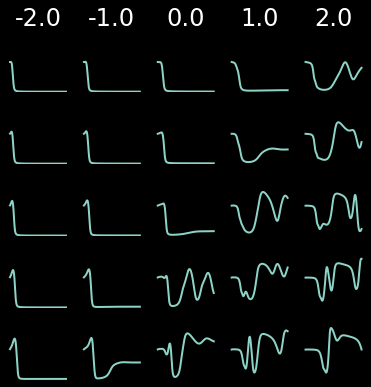

In [21]:
N_GRID = 5
dim_idx = [1, 3]
sensor_ix = 16
samp_amp = 2.0

d0 = np.linspace(-samp_amp, samp_amp, N_GRID)
d1 = np.linspace(-samp_amp, samp_amp, N_GRID)
v0, v1 = np.meshgrid(d0, d1)

for pl_ix in range(N_GRID**2):
    latent = np.zeros((1, LATENT_DIM), dtype=np.float32)
    latent[0, dim_idx[0]] = v0.flatten()[pl_ix]
    latent[0, dim_idx[1]] = v1.flatten()[pl_ix]
    gen_data = decode_model(latent).numpy()[0]

    plt.subplot(N_GRID, N_GRID, pl_ix + 1)
    plt.plot(gen_data[:, sensor_ix])
    plt.axis('off')
    plt.ylim([-1, 1])
    
#     if (pl_ix + 1) % N_GRID == 1:
#         plt.ylabel(f"{latent[0, dim_idx[1]]:.1f}")
    if pl_ix < N_GRID:
        plt.title(f"{latent[0, dim_idx[0]]:.1f}")
